In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import pandas as pd

import keras
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Conv1D, MaxPooling1D, GlobalMaxPool1D, Dropout, Input, Masking, TimeDistributed
from keras.layers import LSTM, GRU
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import Concatenate


from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
filters = '!"#%&()*+,-./:;<=>?@[\]^_`{|}~\'„““-–«' + '0123456789' + '\t\n\r'

In [3]:
data = pd.read_excel('data/FN_Training_Set.xlsx')
train, test = train_test_split(data, test_size=0.1, random_state=999)
train = train.dropna(subset=['Content'])

In [4]:
## train tokenizer

tokenizer = Tokenizer(num_words=10000, filters=filters, lower=True, split=" ")
print('fit on ', len(train))
tokenizer.fit_on_texts(train.Content)
print('tokens', len(tokenizer.word_counts))

# ## save tokenizer
# joblib.dump(tokenizer, 'tokenizer')

## load tokenizer
# tokenizer = joblib.load('tokenizer')

# ## check some words:
tokenizer.texts_to_sequences(['здравей Бойко'])
# [[61, 61, 33, 531, 5, 5, 5]]

fit on  2525
tokens 94022


[[526]]

In [5]:
tokenizer.word_counts

{'боледуване': 22,
 'вършили': 1,
 'от\xa0управлението': 1,
 'bf': 14,
 'овд': 6,
 'съдебните': 7,
 'богия': 1,
 'дибромоетан': 1,
 'критичността': 1,
 'неразпознаваем': 2,
 'геноцидът': 1,
 'помитат': 1,
 'трибунала': 3,
 'вторачиха': 1,
 'трасплантации': 1,
 'енергоресурси': 2,
 'ненаситно': 4,
 'прякорите': 1,
 'изплува': 31,
 'спазмите': 1,
 'здравна': 19,
 'топлина': 55,
 'бурканчета': 2,
 'внезапен': 10,
 'еволюция': 17,
 'премахване': 24,
 'бьющие': 1,
 'изповядва': 14,
 'лекцията': 6,
 'фонда': 31,
 'шевовете': 12,
 'фбр': 32,
 'разпространят': 25,
 'or': 6,
 'връзка': 423,
 'упадък': 9,
 'xapдaл': 2,
 'проверява': 7,
 'раздробяване': 3,
 'превала': 2,
 'подла': 15,
 'мини…': 1,
 'нелечима': 1,
 'докарали': 9,
 'повърхностните': 2,
 'булките': 7,
 'следва': 199,
 'предотвратите': 1,
 'светкавицата': 1,
 'храносмилането': 10,
 'лишили': 3,
 'заработва': 2,
 'home': 13,
 'позагуби': 2,
 'огнена': 18,
 'увисна': 3,
 'лениви': 1,
 'унищожителни': 1,
 'илинденско': 1,
 'ядрените': 3

In [9]:
from keras.callbacks import *
from keras.regularizers import l2
from keras.layers import Input, Embedding, LSTM, Dense, merge, TimeDistributed, Dropout, Lambda, Permute, Reshape, RepeatVector, Activation, Flatten

def attention(input_layer, n_units=64, maxlen=(20,20), name='attention'):
    k = 2 * n_units  
    L = maxlen[0]  
    N = sum(maxlen) + 1  # for delim
    gru_fwd = GRU(n_units, return_sequences=True, name=name+'_gru_fwd')(input_layer)
    gru_bwd = GRU(n_units, return_sequences=True, go_backwards=True, name=name+'_gru_bwd')(input_layer)
    bigru = merge([gru_fwd, gru_bwd], name=name+'_bigru', mode='concat')
    drop_out = Dropout(0.1)(bigru)
    h_n = Lambda(get_H_n, output_shape=(k,), name=name+"_h_n")(drop_out)
    Y = Lambda(get_Y, arguments={"xmaxlen": L}, name=name+"_Y", output_shape=(L, k))(drop_out)
    Whn = Dense(k, W_regularizer=l2(0.01), name=name+"_Wh_n")(h_n)
    Whn_x_e = RepeatVector(L, name=name+"_Wh_n_x_e")(Whn)
    WY = TimeDistributed(Dense(k, W_regularizer=l2(0.01)), name=name+"_WY")(Y)
    merged = merge([Whn_x_e, WY], name=name+"_merged", mode='sum')
    M = Activation('tanh', name=name+"_M")(merged)

    alpha_ = TimeDistributed(Dense(1, activation='linear'), name=name+"_alpha_")(M)
    flat_alpha = Flatten(name=name+"_flat_alpha")(alpha_)
    alpha = Dense(L, activation='softmax', name=name+"_alpha")(flat_alpha)

    Y_trans = Permute((2, 1), name=name+"_y_trans")(Y)  # of shape (None,300,20)

    r_ = merge([Y_trans, alpha], output_shape=(k, 1), name=name+"_r_", mode=get_R)

    r = Reshape((k,), name=name+"_r")(r_)
    Wr = Dense(k, W_regularizer=l2(0.01))(r)
    Wh = Dense(k, W_regularizer=l2(0.01))(h_n)
    return merge([Wr, Wh], mode='sum')
    #return Reshape((1, k))(merged)

def get_H_n(X):
    ans = X[:, -1, :]  # get last element from time dim
    return ans


def get_Y(X, xmaxlen):
    return X[:, :xmaxlen, :]  # get first xmaxlen elem from time dim


def get_R(X):
    Y, alpha = X[0], X[1]
    ans = K.batch_dot(Y, alpha)
    return ans



In [10]:
def create_model(num_words):
    seq_inp = Input(shape=(None,), dtype='int32', name='sequential_input')
    embedding = Embedding(num_words, 64, mask_zero=True)(seq_inp)
    rnn = Bidirectional(GRU(64, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), 
                            recurrent_dropout=0.05, dropout=0.3, return_sequences=True))(embedding)
    rnn = attention(rnn)
    rnn = Dense(1, activation='softmax')(rnn)
    
    return seq_inp, rnn


In [11]:
embedding_size = 64
num_words = tokenizer.num_words

## Words
model_input, model_output = create_model(num_words)
model = Model(inputs=[model_input], outputs=model_output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/Users/lacho/.pyenv/versions/3.5.1/envs/hack_fake_news/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # This is added back by InteractiveShellApp.init_path()
/Users/lacho/.pyenv/versions/3.5.1/envs/hack_fake_news/lib/python3.5/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/lacho/.pyenv/versions/3.5.1/envs/hack_fake_news/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_regularizer=<keras.reg..., name="attention_Wh_n")`
  from ipykernel import kernelapp as app
/Users/lacho/.pyenv/versions/3.5.1/envs/hack_fake_news/lib/python3.5/site-packages/ipykernel_launcher.py:17: Use

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
sequential_input (InputLayer)    (None, None)          0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, None, 64)      640000      sequential_input[0][0]           
____________________________________________________________________________________________________
bidirectional_2 (Bidirectional)  (None, None, 128)     49536       embedding_2[0][0]                
____________________________________________________________________________________________________
attention_gru_fwd (GRU)          (None, None, 64)      37056       bidirectional_2[0][0]            
___________________________________________________________________________________________

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model_gru.png', show_shapes=True)

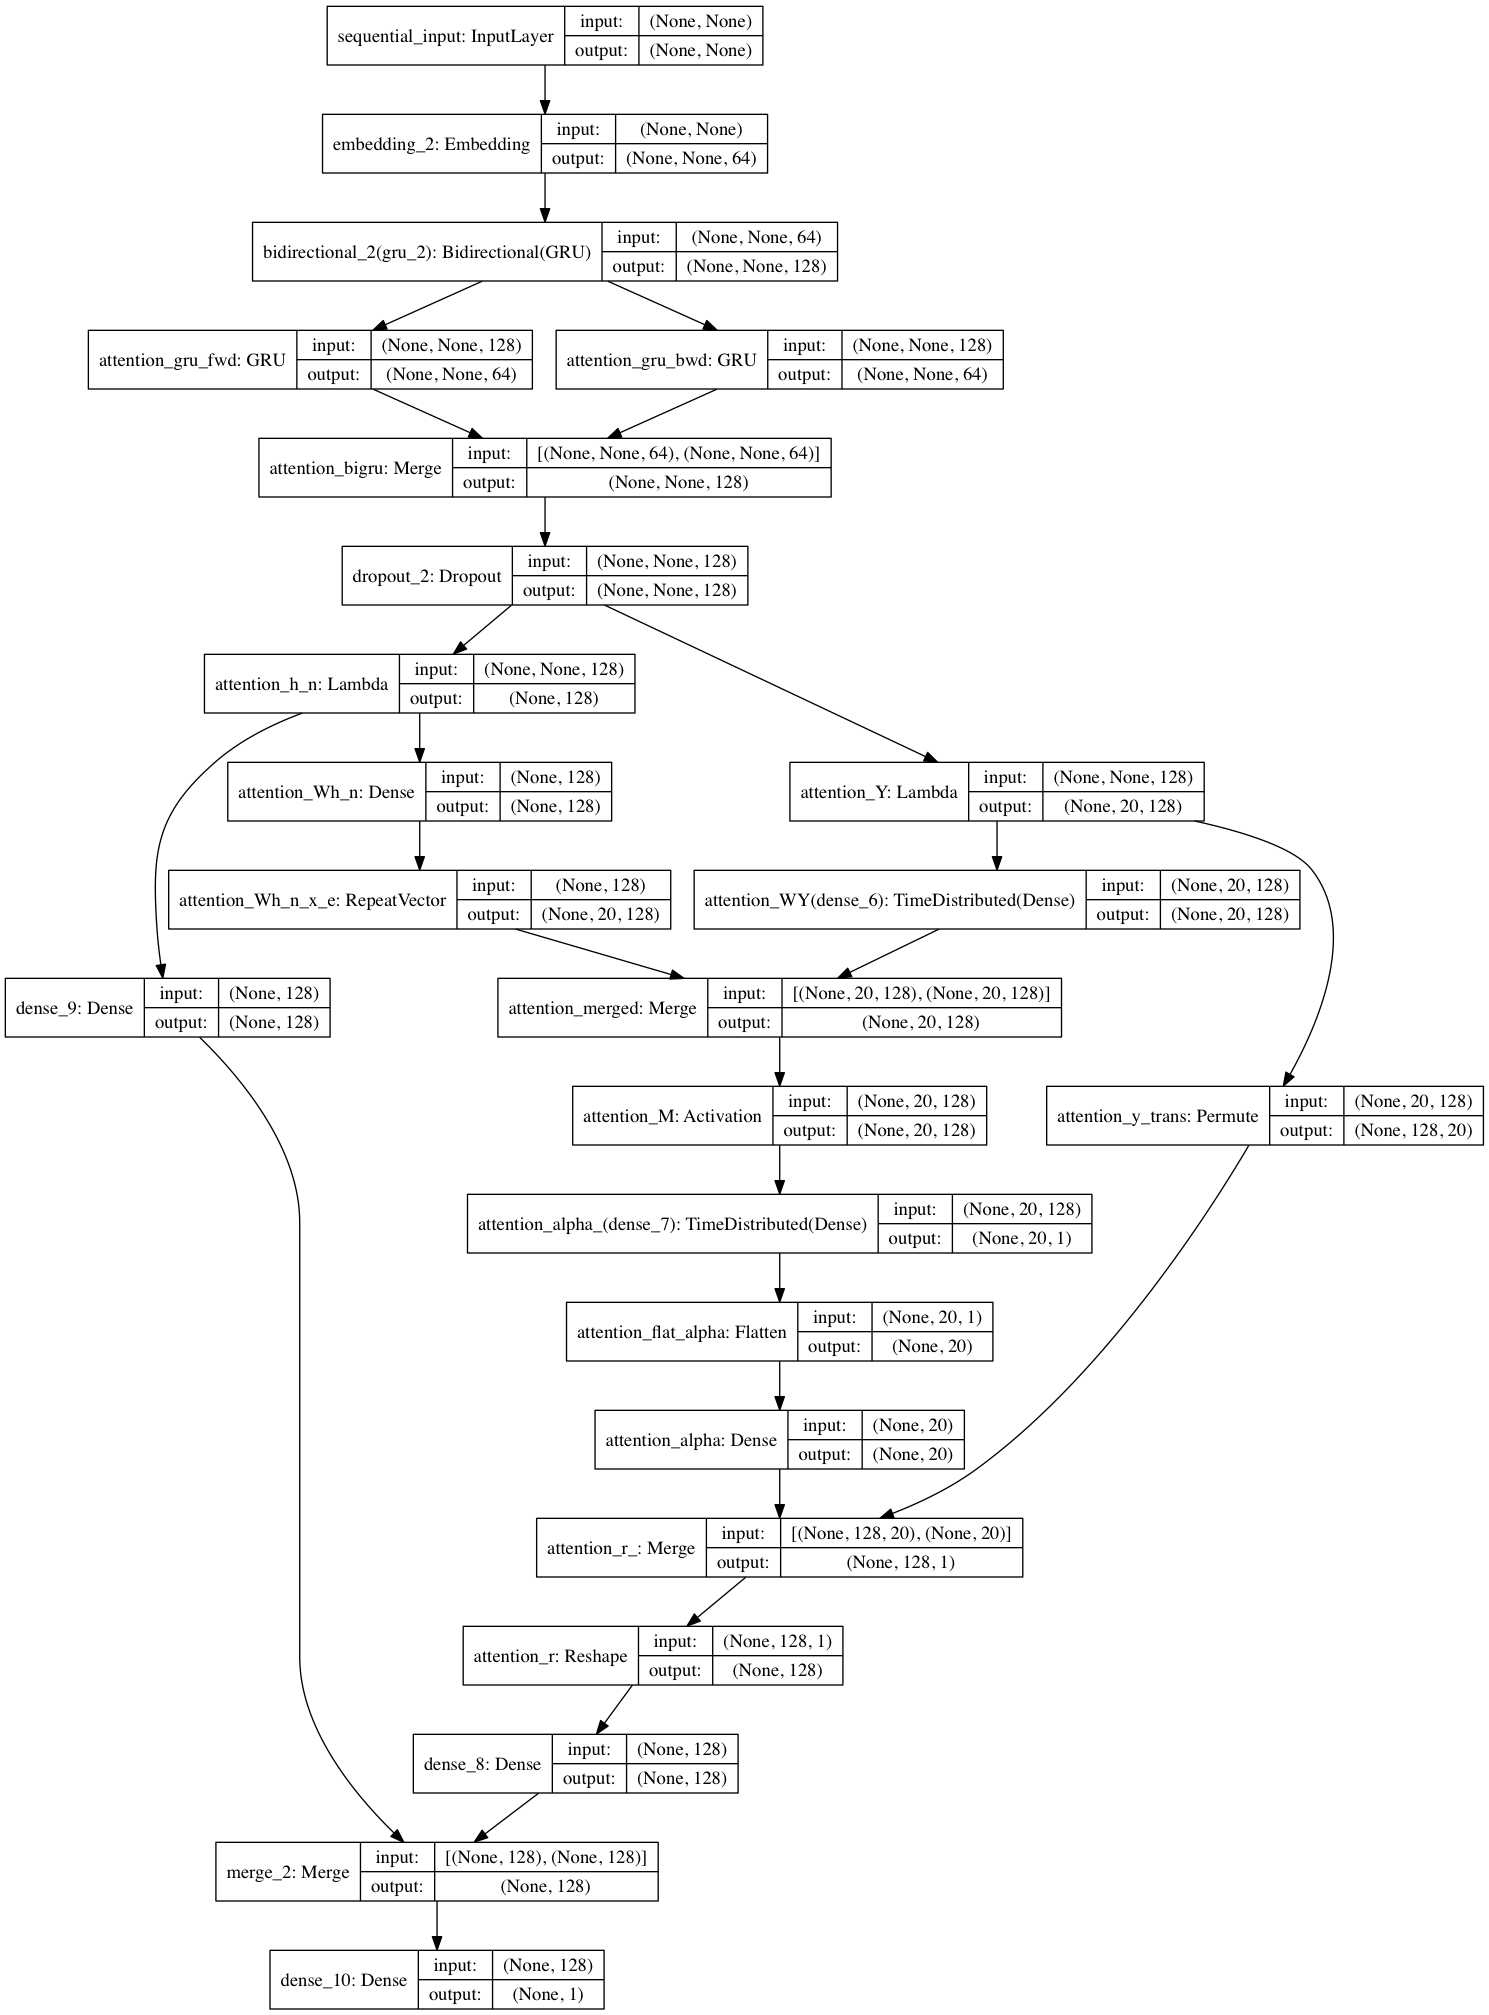

In [13]:
from IPython.display import Image
Image("model_gru.png")

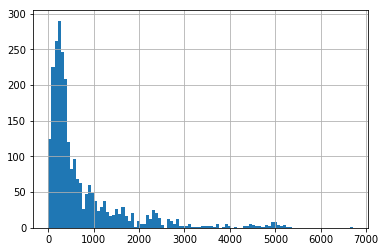

In [14]:
train.Content.apply(lambda t: len(t.split())).hist(bins=100)

In [15]:
def batch_generator(df, n=100, is_shuffle=True):
    
    l = len(df)
    while True:
        
        if is_shuffle:
            df = shuffle(df)

        for ndx in range(0, l, n):
            x = df.Content

            
            _x = tokenizer.texts_to_sequences(x[ndx:min(ndx + n, l)])
            maxlen = min(max(map(len, _x)), 2000)
            _x = sequence.pad_sequences(_x, maxlen=maxlen)

            
                
            yield _x, train.fake_news_score[ndx:min(ndx + n, l)] == 3

In [16]:
from datetime import datetime
now = datetime.now()
experiment_name = 'exp_rnn_attention'
log_dir = 'logs/' + now.strftime("%Y%m%d-%H%M%S-") + experiment_name + "/"

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0.1, write_graph=True, write_images=False)
checkpointer = ModelCheckpoint(filepath="models_checkpoints/" + experiment_name + ".hdf5", verbose=1, save_best_only=True)
batch_size = 100

history = model.fit_generator(batch_generator(train, n=batch_size), 
                              epochs=10,
                              initial_epoch=0, 
                              steps_per_epoch = len(train) // batch_size,
                              validation_data=batch_generator(test, n=batch_size, is_shuffle=False),
                              validation_steps=len(test) // batch_size,
                              callbacks=[tensorboard, checkpointer])

history_temp = history

INFO:tensorflow:Summary name embedding_2/embeddings:0 is illegal; using embedding_2/embeddings_0 instead.
INFO:tensorflow:Summary name bidirectional_2/forward_gru_2/kernel:0 is illegal; using bidirectional_2/forward_gru_2/kernel_0 instead.
INFO:tensorflow:Summary name bidirectional_2/forward_gru_2/recurrent_kernel:0 is illegal; using bidirectional_2/forward_gru_2/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name bidirectional_2/forward_gru_2/bias:0 is illegal; using bidirectional_2/forward_gru_2/bias_0 instead.
INFO:tensorflow:Summary name bidirectional_2/backward_gru_2/kernel:0 is illegal; using bidirectional_2/backward_gru_2/kernel_0 instead.
INFO:tensorflow:Summary name bidirectional_2/backward_gru_2/recurrent_kernel:0 is illegal; using bidirectional_2/backward_gru_2/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name bidirectional_2/backward_gru_2/bias:0 is illegal; using bidirectional_2/backward_gru_2/bias_0 instead.
INFO:tensorflow:Summary name attention_gru_fwd_1/ker

KeyboardInterrupt: 